In [11]:
#pip install selenium beautifulsoup4 pandas

In [12]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd

# 드라이버 설정
driver_path = "C:/tools/chromedriver-win64/chromedriver.exe"
service = Service(executable_path=driver_path)
options = Options()
options.add_argument("--start-maximized")
options.add_experimental_option("detach", True)  # 브라우저 자동 종료 방지
driver = webdriver.Chrome(service=service, options=options)

# 상품 상세 페이지 열기
url = "https://brand.naver.com/popmart/products/10643619141"
driver.get(url)
wait = WebDriverWait(driver, 10)

# [1] 리뷰 보기 버튼 클릭
try:
    time.sleep(2)  # 페이지 초기 로딩 대기
    driver.execute_script("window.scrollBy(0, 1000)")  # 아래로 스크롤해야 리뷰 탭 보임 O
    review_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div a._2IbcpXeCHH")))
    review_tab.click()
    #time.sleep(2)
    #driver.execute_script("window.scrollBy(7433, 8333)")
    print("✅ 리뷰 보기 버튼 클릭 완료")
except Exception as e:
    print("❌ 리뷰 보기 버튼 클릭 실패:", e)


# ✅ 4. 리뷰 수집
review_list = []

# ✅ 수집할 페이지 수 지정 (예: 5페이지 x 20개 = 최대 100개 리뷰)
for page in range(5):
    time.sleep(2)

    # ✅ 현재 페이지의 리뷰 20개 추출 
    try:
        review_items = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div._1kMfD5ErZ6 > span._2L3vDiadT9'))
        )
        for r in review_items:
            text = r.text.strip()
            if text:
                review_list.append(text)
        print(f"✅ {page + 1}페이지 리뷰 {len(review_items)}개 수집 완료")
    except:
        print(f"❌ {page + 1}페이지 리뷰 로딩 실패")
        break

# 종료
time.sleep(3)
driver.quit()

# 저장
df = pd.DataFrame(review_list, columns=["review"])
df.to_csv("store_reviews.csv", index=False, encoding="utf-8-sig")
print("총 수집된 리뷰 수:", len(df))
df.head()

✅ 리뷰 보기 버튼 클릭 완료
✅ 1페이지 리뷰 20개 수집 완료
✅ 2페이지 리뷰 20개 수집 완료
✅ 3페이지 리뷰 20개 수집 완료
✅ 4페이지 리뷰 20개 수집 완료
✅ 5페이지 리뷰 20개 수집 완료
총 수집된 리뷰 수: 100


,review
0,어렵게어렵게 드디어 라부부!!!\n못살줄알았는데 성공했습니다.\n라부부를 살수있다는...
1,아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...
2,귀엽기는 엄청 귀여워요 3시 좀 넘어서 어찌저찌 6개 구매했어유 너무 ㄱ신나고 기대...
3,되팔이들한테 안낚이고 정상가로 구매한 나녀석 넘 칭찬함 ㅋㅋㅋ\n너~~~~~무너무 ...
4,대기하다 운좋게 두개 구입!\n처음 도전이었는데 구입할수있어서 너무감사ㅠㅠ\n하나는...


In [13]:
import re

def clean_review(text):
    # 1. 이모지 제거
    text = re.sub(r'[^\w\s.,!?ㄱ-ㅎㅏ-ㅣ가-힣]', '', text)

    # 2. 특수문자 제거 (기본적인 문장부호는 남김)
    text = re.sub(r'[_~^·•☆★▶️✔️❤]+', '', text)

    # 3. 반복 자음/모음 제거
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # ㅋㅋㅋㅋ → ㅋㅋ

    # 4. 줄바꿈 제거
    text = re.sub(r'\n', ' ', text)
    
    # 5. 너무 짧은 리뷰 제거
    if len(text.strip()) < 5:
        return None
    
    return text.strip()


In [14]:
# 전처리된 리스트 생성
cleaned_reviews = []

for review in review_list:
    cleaned = clean_review(review)
    if cleaned:
        cleaned_reviews.append(cleaned)

print(f"✅ 전처리 완료! 유효한 리뷰 개수: {len(cleaned_reviews)}")

# 다시 CSV 저장
import pandas as pd
df = pd.DataFrame({'review': cleaned_reviews})
df.to_csv("naver_reviews_cleaned.csv", index=False, encoding='utf-8-sig')


✅ 전처리 완료! 유효한 리뷰 개수: 100


In [15]:
#pip install transformers torch pandas tqdm

In [16]:
# KoBART 요약 모델 로드

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# KoBART 요약 모델 (SKT-AI 공개 모델)
tokenizer = PreTrainedTokenizerFast.from_pretrained("digit82/kobart-summarization")
model = BartForConditionalGeneration.from_pretrained("digit82/kobart-summarization")


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


In [17]:
# 리뷰 불러와 요약 실행

import pandas as pd
from tqdm import tqdm

# 전처리된 리뷰 파일 불러오기
df = pd.read_csv("naver_reviews_cleaned.csv")
df = df.dropna()

# 요약 컬럼 생성
summaries = []
for review in tqdm(df['review']):
    try:
        summary = kobart_summarize(review)
    except:
        summary = "요약 실패"
    summaries.append(summary)

df['summary'] = summaries


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 209715.20it/s]


In [18]:
# 결과 저장

df.to_csv("naver_reviews_summary_kobart.csv", index=False, encoding='utf-8-sig')
print("✅ 저장 완료!")

✅ 저장 완료!


In [19]:
# KoELECTRA 감성분석

from transformers import ElectraTokenizer, ElectraForSequenceClassification
import torch

# 모델과 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-discriminator")
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-discriminator", num_labels=2)
model.eval()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [20]:
# 감정 분석 함수

def predict_sentiment(text):
    # 입력 전처리
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    
    # 모델 추론
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1).item()
    
    # 결과 반환
    return "긍정" if predicted == 1 else "부정"


In [21]:
# 요약과 감성분석 함께 적용

from tqdm import tqdm
import pandas as pd

# 리뷰 데이터 불러오기
df = pd.read_csv("naver_reviews_cleaned.csv").dropna()

# 결과 저장용 리스트
summaries = []
sentiments = []

# 반복 처리
for review in tqdm(df['review']):
    try:
        summary = kobart_summarize(review)
        sentiment = predict_sentiment(review)
    except:
        summary = "요약 실패"
        sentiment = "분석 실패"
    
    summaries.append(summary)
    sentiments.append(sentiment)

df['summary'] = summaries
df['sentiment'] = sentiments


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 572992.35it/s]


In [22]:
# 최종 결과 저장

df.to_csv("naver_reviews_summary_sentiment.csv", index=False, encoding='utf-8-sig')
print("✅ 요약 + 감성분석 저장 완료")


✅ 요약 + 감성분석 저장 완료


In [23]:
# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("naver_reviews_summary_sentiment.csv")
df = df.dropna(subset=["sentiment"])
df.head()


,review,summary,sentiment
0,어렵게어렵게 드디어 라부부!! 못살줄알았는데 성공했습니다. 라부부를 살수있다는 응모...,요약 실패,분석 실패
1,아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...,요약 실패,분석 실패
2,귀엽기는 엄청 귀여워요 3시 좀 넘어서 어찌저찌 6개 구매했어유 너무 ㄱ신나고 기대...,요약 실패,분석 실패
3,되팔이들한테 안낚이고 정상가로 구매한 나녀석 넘 칭찬함 ㅋㅋ 너무너무 귀여워요. 새...,요약 실패,분석 실패
4,대기하다 운좋게 두개 구입! 처음 도전이었는데 구입할수있어서 너무감사ㅠㅠ 하나는 저...,요약 실패,분석 실패


In [24]:
# 감성 분포 확인

# 감정 라벨 분포
#sentiment_counts = df["sentiment"].value_counts()
#print(sentiment_counts)


In [27]:
# 1. 라이브러리 설치 (필요 시)
#!pip install transformers tqdm selenium pandas torch --quiet

# 2. 필요한 모듈 임포트
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
import re
import pandas as pd
from tqdm import tqdm
import torch

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ----------------------------------------------

# 3. 크롬 드라이버 설정 및 네이버스토어 리뷰 페이지 열기
driver_path = "C:/tools/chromedriver-win64/chromedriver.exe"  # 크롬드라이버 경로 수정 필요

service = Service(executable_path=driver_path)
options = Options()
options.add_argument("--start-maximized")
options.add_experimental_option("detach", True)  # 브라우저 닫히지 않게 유지

driver = webdriver.Chrome(service=service, options=options)

url = "https://brand.naver.com/popmart/products/10643619141"  # 예시 상품 URL
driver.get(url)
wait = WebDriverWait(driver, 10)

# 리뷰 탭 클릭 (상품 페이지 스크롤 후 클릭)
time.sleep(3)
driver.execute_script("window.scrollBy(0, 1000)")

try:
    # 리뷰 탭 버튼 찾기 (CSS Selector는 사이트 구조에 따라 변경 가능)
    review_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div a._2IbcpXeCHH")))
    review_tab.click()
    print("✅ 리뷰 탭 클릭 성공")
except Exception as e:
    print("❌ 리뷰 탭 클릭 실패:", e)

time.sleep(3)

# ----------------------------------------------

# 4. 리뷰 크롤링 함수 (한 페이지 리뷰 수집 및 다음 페이지 이동)

def crawl_reviews(pages=5):
    review_texts = []
    for page in range(pages):
        time.sleep(2)
        try:
            time.sleep(2)  # 페이지 초기 로딩 대기
            driver.execute_script("window.scrollBy(0, 1000)")  # 리뷰 탭 보이도록 스크롤
            review_tab = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "a._2IbcpXeCHH")))
            review_tab.click()
            print("✅ 리뷰 보기 버튼 클릭 완료")
        except Exception as e:
            print("❌ 리뷰 보기 버튼 클릭 실패:", e)

review_list = []

# 5페이지 크롤링 반복
for page in range(5):
    time.sleep(2)

    # 리뷰 20개 수집 시도
    try:
        review_items = wait.until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div._1kMfD5ErZ6 > span._2L3vDiadT9'))
        )
        for r in review_items:
            text = r.text.strip()
            if text:
                review_list.append(text)
        print(f"✅ {page + 1}페이지 리뷰 {len(review_items)}개 수집 완료")
    except Exception as e:
        print(f"❌ {page + 1}페이지 리뷰 로딩 실패:", e)
        break

    # 다음 페이지 버튼 클릭 (마지막 페이지일 경우 실패 가능)
    try:
        next_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.fAUKm1ewwo._2Ar8-aEUTq._nlog_click[aria-hidden="false"]'))
        )
        next_button.click()
        print("✅ 다음 페이지 버튼 클릭 완료")
    except Exception as e:
        print("❌ 다음 페이지 버튼 클릭 실패:", e)
        break

time.sleep(3)
driver.quit()

# 수집한 리뷰 DataFrame으로 저장
df = pd.DataFrame(review_list, columns=["review"])
df.to_csv("naver_store_reviews.csv", index=False, encoding="utf-8-sig")
print(f"총 수집된 리뷰 수: {len(df)}")

driver.quit()

# ----------------------------------------------

# 5. 리뷰 전처리 함수

def clean_review(text):
    text = re.sub(r'[^\w\s.,!?ㄱ-ㅎㅏ-ㅣ가-힣]', '', text)  # 이모지 제거
    text = re.sub(r'[_~^·•☆★▶️✔️❤]+', '', text)           # 특수문자 제거
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)             # 반복 자음/모음 축소
    text = re.sub("\n", " ", text)                          # 줄바꿈 제거
    if len(text.strip()) < 5:
        return None
    return text.strip()

cleaned_reviews = [clean_review(r) for r in review_list]
cleaned_reviews = [r for r in cleaned_reviews if r]

print(f"✅ 전처리 완료, 유효 리뷰 개수: {len(cleaned_reviews)}")

df = pd.DataFrame({'review': cleaned_reviews})
df.to_csv("naver_reviews_cleaned.csv", index=False, encoding='utf-8-sig')

# ----------------------------------------------

# 6. KoBART 요약 모델 로드

tokenizer_kobart = PreTrainedTokenizerFast.from_pretrained("digit82/kobart-summarization")
model_kobart = BartForConditionalGeneration.from_pretrained("digit82/kobart-summarization")
model_kobart.eval()

def kobart_summarize(text):
    if len(text) < 10:
        return "요약 불가"
    inputs = tokenizer_kobart.encode(text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model_kobart.generate(inputs, max_length=64, min_length=10, length_penalty=2.0,
                                       num_beams=4, early_stopping=True)
    summary = tokenizer_kobart.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# ----------------------------------------------

# 7. KoELECTRA 감성분석 모델 로드 (감성분석용 fine-tuned 모델)

tokenizer_electra = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")
model_electra = AutoModelForSequenceClassification.from_pretrained("beomi/KcELECTRA-base")
model_electra.eval()

def predict_sentiment(text):
    inputs = tokenizer_electra(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model_electra(**inputs)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1).item()
    return "긍정" if predicted == 1 else "부정"

# ----------------------------------------------

# 8. 리뷰에 요약과 감성분석 함께 적용

summaries = []
sentiments = []

for review in tqdm(df['review']):
    try:
        summary = kobart_summarize(review)
        sentiment = predict_sentiment(review)
    except Exception as e:
        summary = "요약 실패"
        sentiment = "분석 실패"
    summaries.append(summary)
    sentiments.append(sentiment)

df['summary'] = summaries
df['sentiment'] = sentiments

# ----------------------------------------------

# 9. 최종 결과 저장

df.to_csv("naver_reviews_summary_sentiment.csv", index=False, encoding='utf-8-sig')
print("✅ 요약 및 감성분석 완료, 결과 저장 완료!")


✅ 리뷰 탭 클릭 성공
✅ 1페이지 리뷰 20개 수집 완료
✅ 다음 페이지 버튼 클릭 완료
✅ 2페이지 리뷰 20개 수집 완료
✅ 다음 페이지 버튼 클릭 완료
✅ 3페이지 리뷰 20개 수집 완료
✅ 다음 페이지 버튼 클릭 완료
✅ 4페이지 리뷰 20개 수집 완료
✅ 다음 페이지 버튼 클릭 완료
✅ 5페이지 리뷰 20개 수집 완료
✅ 다음 페이지 버튼 클릭 완료
총 수집된 리뷰 수: 100
✅ 전처리 완료, 유효 리뷰 개수: 100


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]

✅ 요약 및 감성분석 완료, 결과 저장 완료!


In [30]:
df2 = pd.read_csv("naver_reviews_summary_sentiment.csv")
print(df2.head())

                                              review  \
0  어렵게어렵게 드디어 라부부!! 못살줄알았는데 성공했습니다. 라부부를 살수있다는 응모...   
1  아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...   
2  귀엽기는 엄청 귀여워요 3시 좀 넘어서 어찌저찌 6개 구매했어유 너무 ㄱ신나고 기대...   
3  되팔이들한테 안낚이고 정상가로 구매한 나녀석 넘 칭찬함 ㅋㅋ 너무너무 귀여워요. 새...   
4  대기하다 운좋게 두개 구입! 처음 도전이었는데 구입할수있어서 너무감사ㅠㅠ 하나는 저...   

                                             summary sentiment  
0  귀여운 라부부를 살수있다는 응모도 해보고 응모도 해보고 했지만 다 실패하던 중에, ...        부정  
1  아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...        부정  
2  토피 색상은 얼굴에 지워지지 않는 잉크같은게 묻었는데 교환은 한달 가까이 걸린데서 ...        부정  
3  새로고침 광클에 대기자 6천가까이 됐었는데 뒤로가기 안누르고 차분히 기다린 보람이 있어요        부정  
4  운좋게 두개 구입하여 처음 도전이었는데 구입할수있어서 너무감사 하나는 저 쓰고 하나...        부정  


In [31]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     100 non-null    object
 1   summary    100 non-null    object
 2   sentiment  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB
None


In [8]:
import sys
!{sys.executable} -m pip install wordcloud

  Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl (300 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [10]:
# 감성분석 + 요약이 저장된 파일 불러오기
df = pd.read_csv("naver_reviews_summary_sentiment.csv")

# 기본 구조 확인
print(df.head())
print(df['sentiment'].value_counts())


                                              review  \
0  어렵게어렵게 드디어 라부부!! 못살줄알았는데 성공했습니다. 라부부를 살수있다는 응모...   
1  아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...   
2  귀엽기는 엄청 귀여워요 3시 좀 넘어서 어찌저찌 6개 구매했어유 너무 ㄱ신나고 기대...   
3  되팔이들한테 안낚이고 정상가로 구매한 나녀석 넘 칭찬함 ㅋㅋ 너무너무 귀여워요. 새...   
4  대기하다 운좋게 두개 구입! 처음 도전이었는데 구입할수있어서 너무감사ㅠㅠ 하나는 저...   

                                             summary sentiment  
0  귀여운 라부부를 살수있다는 응모도 해보고 응모도 해보고 했지만 다 실패하던 중에, ...        부정  
1  아이가 라부부 한번 검색 해 보라고 했을땐 그게 뭐야 하고 그냥 넘겼었는데 우연히 ...        부정  
2  토피 색상은 얼굴에 지워지지 않는 잉크같은게 묻었는데 교환은 한달 가까이 걸린데서 ...        부정  
3  새로고침 광클에 대기자 6천가까이 됐었는데 뒤로가기 안누르고 차분히 기다린 보람이 있어요        부정  
4  운좋게 두개 구입하여 처음 도전이었는데 구입할수있어서 너무감사 하나는 저 쓰고 하나...        부정  
sentiment
긍정    54
부정    46
Name: count, dtype: int64


C:\Users\Hyeonseong\AppData\Local\Temp\ipykernel_28360\3243617130.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')


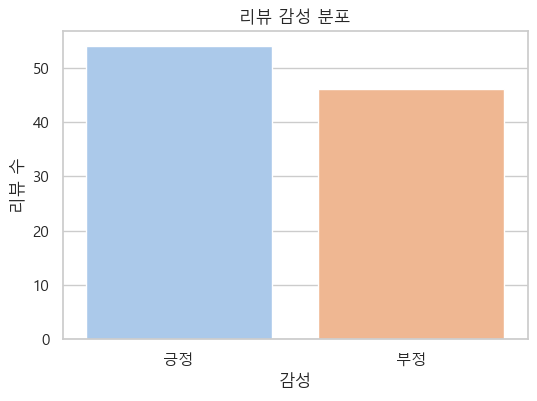

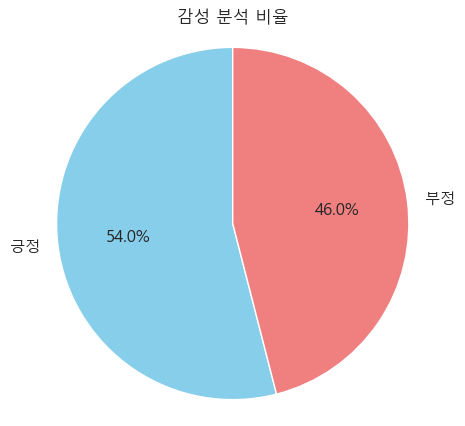

In [14]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 결과 데이터 불러오기
df = pd.read_csv("naver_reviews_summary_sentiment.csv")

# 감성 분포 계산
sentiment_counts = df['sentiment'].value_counts()

# 막대그래프
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
plt.title("리뷰 감성 분포")
plt.xlabel("감성")
plt.ylabel("리뷰 수")
plt.show()

# 파이차트
plt.figure(figsize=(5, 5))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%.1f%%', startangle=90,
        colors=['skyblue', 'lightcoral'])
plt.title("감성 분석 비율")
plt.axis('equal')
plt.show()


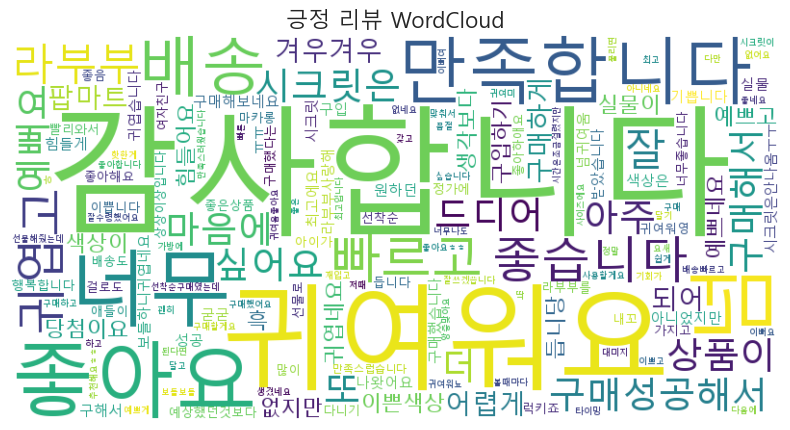

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("naver_reviews_summary_sentiment.csv")

# ✅ Windows용 한글 폰트 경로 지정 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"

# 긍정 리뷰만 추출하여 하나의 문자열로 결합
positive_text = ' '.join(df[df['sentiment'] == '긍정']['review'])

# 워드클라우드 생성
wordcloud_pos = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=400
).generate(positive_text)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("긍정 리뷰 WordCloud", fontsize=16)
plt.show()


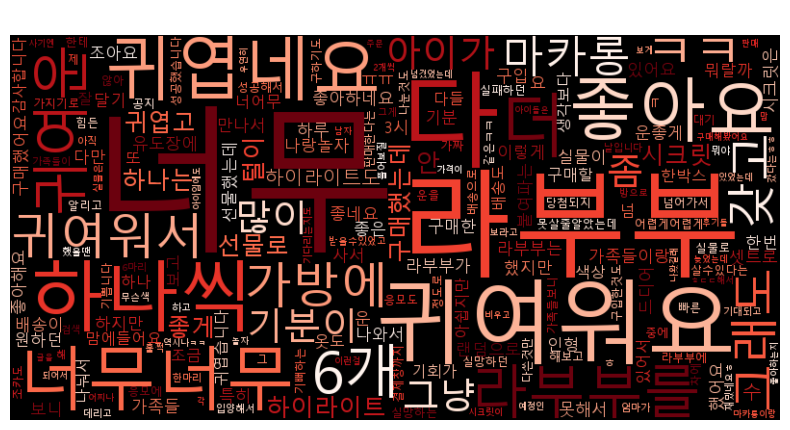

In [17]:
# 부정 리뷰
negative_text = ' '.join(df[df['sentiment'] == '부정']['review'])

wordcloud_neg = WordCloud(
    font_path=font_path,
    background_color='black',
    width=800,
    height=400,
    colormap='Reds'
).generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("부정 리뷰 WordCloud", fontsize=16, color='white')
plt.show()


In [18]:
# 키워드 추출 (저주 언급된 단어 상위 20개 추출)
from collections import Counter
import konlpy
from konlpy.tag import Okt

okt = Okt()

# 모든 리뷰를 하나로 합치기
all_reviews = ' '.join(df['review'])

# 명사 추출
nouns = okt.nouns(all_reviews)
nouns = [n for n in nouns if len(n) > 1]  # 한 글자 제거

# 상위 20개 출력
top_nouns = Counter(nouns).most_common(20)
print(top_nouns)


[('구매', 32), ('부부', 30), ('시크릿', 13), ('하나', 12), ('배송', 12), ('선물', 10), ('가족', 8), ('실물', 7), ('마카롱', 7), ('색상', 7), ('하이라이트', 7), ('구입', 6), ('아이', 6), ('기분', 5), ('가방', 5), ('박스', 4), ('다음', 4), ('기회', 4), ('생각', 4), ('상품', 4)]


In [19]:
#pip install streamlit wordcloud matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


2025-08-04 14:35:39.126 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-04 14:35:39.127 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-08-04 14:35:39.127 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-04 14:35:39.219 
  command:

    streamlit run C:\Users\Hyeonseong\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-04 14:35:39.219 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-04 14:35:39.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-04 14:35:39.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-04 14:35:39.224 Thread 'MainThread': m

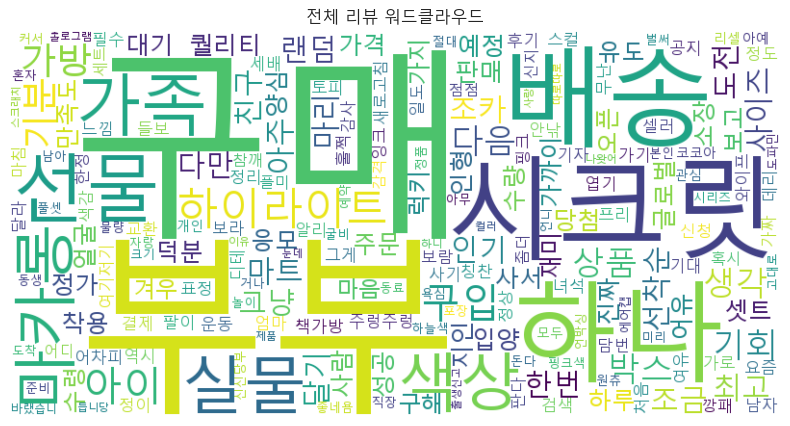

In [20]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt

# 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 불러오기
@st.cache_data
def load_data():
    return pd.read_csv("naver_reviews_summary_sentiment.csv")

df = load_data()

st.title("🛍️ 네이버 스토어 리뷰 분석 대시보드")

# 감정 분포 시각화
st.subheader("1. 감성 분석 분포")
sentiment_counts = df['sentiment'].value_counts()
st.bar_chart(sentiment_counts)

# 워드클라우드 생성 함수
def draw_wordcloud(texts, title):
    okt = Okt()
    nouns = []
    for t in texts:
        nouns += okt.nouns(t)
    nouns = [n for n in nouns if len(n) > 1]
    count = Counter(nouns)
    
    wc = WordCloud(font_path="malgun.ttf", background_color="white", width=800, height=400)
    cloud = wc.generate_from_frequencies(count)

    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    st.pyplot(plt)

# 긍/부정 필터 선택
sentiment_filter = st.selectbox("🔎 감성별 워드클라우드 보기", ['전체', '긍정', '부정'])

if sentiment_filter == '전체':
    draw_wordcloud(df['review'], '전체 리뷰 워드클라우드')
else:
    filtered_df = df[df['sentiment'] == sentiment_filter]
    draw_wordcloud(filtered_df['review'], f'{sentiment_filter} 리뷰 워드클라우드')

# 요약 결과 확인
st.subheader("2. 리뷰 요약 예시")

num_to_show = st.slider("리뷰 개수 선택", 1, 10, 3)
sample_df = df.sample(n=num_to_show)

for i, row in sample_df.iterrows():
    st.markdown(f"**원문**: {row['review']}")
    st.markdown(f"**요약**: {row['summary']}")
    st.markdown(f"**감정**: {row['sentiment']}")
    st.markdown("---")
